### Imports and parameters

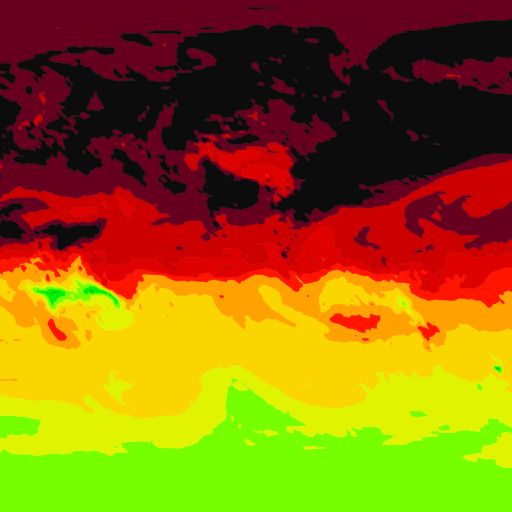

In [241]:
import copy as cp
import numpy as np
import numpy.random as rnd
import PIL.Image as img
import PIL.ImageDraw as imgdr

source_image = img.open("./source_img.png").convert('RGBA')
generation_size = 5
max_generation_cycles = 500
mutation_chance = 0.25
mutation_speed = 5.0
selection_percent = 0.8

source_image

### Image Utils

In [54]:
def distance(image1,image2):
    return np.sum(np.absolute(image2 - image1))

def get_random_color(transparency = 0):
    if transparency == 0:
        transparency =100# np.random.randint(0,255)
    return (np.random.randint(255), np.random.randint(255),np.random.randint(255),transparency)

def change_color(color,dcomp):
    r,g,b,a = color
    r += int(np.clip(0,rnd.uniform(-dcomp,dcomp),255))
    g += int(np.clip(0,rnd.uniform(-dcomp,dcomp),255))
    b += int(np.clip(0,rnd.uniform(-dcomp,dcomp),255))
    a += int(np.clip(0,rnd.uniform(-dcomp,dcomp),255))
    return (r,g,b,a)

### Chromosome

0.0008046551812760988


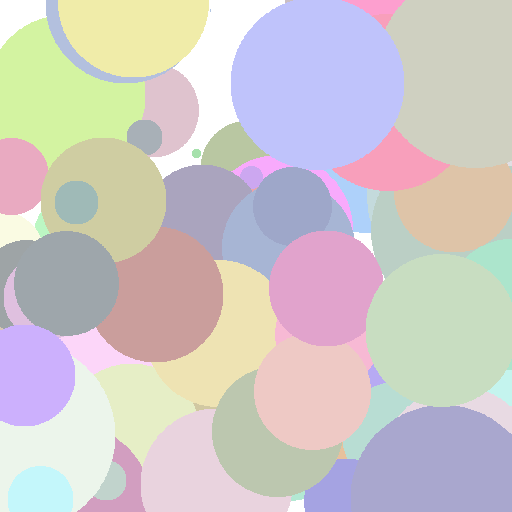

In [271]:
class Gene:
    
    @staticmethod
    def generate_random():
        pass
    
    def draw_at(self,canvas):
        pass
    
    def mutate(self):
        pass
        
class CircleGene:
    
    def __init__(self,x,y,radius,color):
        self.x, self.y = x, y
        self.radius = radius
        self.color = color
        self.fitness = -1
        
    def draw_at(self,canvas):
        x, y = self.x, self.y
        r, c = self.radius, self.color
        canvas.ellipse((x-r,y-r,x+r,y+r),fill=c)
        
    def mutate(self):
        self.x += (rnd.rand()-0.5 ) * 5 * mutation_speed
        self.y += (rnd.rand()-0.5 ) * 5 * mutation_speed
        self.radius += (rnd.rand()-0.5) * 40 * mutation_speed
        self.color = change_color(self.color,rnd.rand()*10*mutation_speed)
        
    @staticmethod
    def generate_random(image):
        w,h = image.size
        x = np.random.uniform(0,w)
        y = np.random.uniform(0,h)
        r = np.random.uniform(0,100)
        gene = CircleGene(x,y,r,get_random_color())
        return gene
        
        
class Chromosome:
    
    def __init__(self,genes = [],genes_count = 600):
        self.genes = genes
        self.fitness = -1
        self.genes_count = genes_count
        
    @staticmethod
    def generate_random(image,genes_count=100):
        genes = []
        for i in range(genes_count):
            gene = CircleGene.generate_random(image)
            genes.append(gene)
        chromosome = Chromosome(genes=genes,genes_count=genes_count)
        chromosome.get_fitness(image)
        return chromosome
    
    def get_fitness(self,target_image):
        if self.fitness != -1:
            return self.fitness
        w,h = target_image.size
        self.image = img.new('RGBA',target_image.size)
        canvas = imgdr.Draw(self.image, 'RGBA')
        for i in range(self.genes_count):
            self.genes[i].draw_at(canvas)
        dist = distance(np.array(target_image),np.array(self.image))
        self.fitness = 100000/(100 + dist)
        return self.fitness

    def __lt__(self, other):
        if isinstance(other,float):
            return self.fitness < other
        elif isinstance(other,Chromosome):
            return self.fitness < other.fitness
        else: 
            False
            
    def __str__(self):
        return "Chromosome :fitness = {}".format(self.fitness)

    
ch = Chromosome.generate_random(source_image)
print(ch.get_fitness(source_image))
ch.image

### Breeding

In [248]:
class Breeder:
    #inject self.engine
    
    def __call__(self,chromosomes):
        #return chromosomes in pairs
        pass
    
class InBreeder:
    
    def __init__(self):
        self.engine = None
        
    def __call__(self,chromosomes):
        res = []
        sorted_chs = cp.deepcopy(chromosomes)
        sorted_chs.sort(reverse=True)
        size = len(sorted_chs)
        for i in range(0,int(size),2):
            res.append((sorted_chs[i],sorted_chs[i+1]))
        return res
    
class UsualBreeder:
    
    def __init__(self):
        self.engine = None
        
    def __call__(self,chromosomes):
        res = []
        sorted_chs = cp.deepcopy(chromosomes)
        size = len(sorted_chs)
        for i in range(0,int(size),2):
            res.append((sorted_chs[i],sorted_chs[i+1]))
        return res

### Mutation

In [255]:
class Mutator:
    #inject self.engine
    
    def __call__(self,chromosome):
        # mutation of chromosome
        pass

    
class SelectiveMutator:
    
    def __init__(self):
        self.engine = None
        
    def __call__(self,chromosome):
        chromosome.fitness = -1
        index = rnd.randint(0, chromosome.genes_count)
        chromosome.genes[index].mutate()
        chromosome.get_fitness(source_image)
        return chromosome


### Crossover

0.000809533303807495


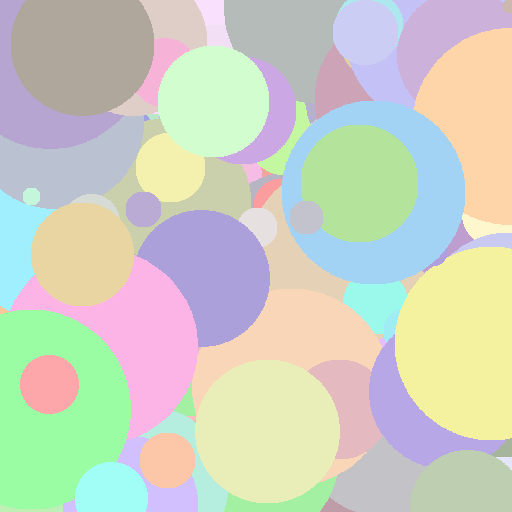

In [274]:
class Crossoverer:
    #inject self.engine
    
    def __call__(self,chromosome1,chromosome2):
        #return (new_chromosome1,new_chromosome2)
        pass
    
class SinglePointCrossoverer:
    
    def __init__(self):
        self.engine = None
    
    def __call__(self,chromosome1,chromosome2):
        if chromosome1.genes_count != chromosome2.genes_count:
            return (chromosome1,chromosome2)
        crossover_point = rnd.randint(chromosome1.genes_count)
        gc = chromosome1.genes_count
        new_ch1, new_ch2 = cp.copy(chromosome1),cp.copy(chromosome2)
        for i in range(crossover_point):
            new_ch1.genes[i], new_ch2.genes[i] = copy(chromosome2.genes[i]), copy(chromosome1.genes[i])
        new_ch1.fitness = -1
        new_ch2.fitness = -1
        return new_ch1, new_ch2
    
class RandomPointCrossoverer:
    
    #def __init__(self):
     #   self.engine = None
        
    def __call__(self,chromosome1,chromosome2):
        if chromosome1.genes_count != chromosome2.genes_count:
            return (chromosome1,chromosome2)
        crossover_point = rnd.randint(chromosome1.genes_count)
        for i in range(crossover_point):
            if rnd.rand() > 0.5:
                chromosome1.genes[i], chromosome2.genes[i] = chromosome2.genes[i], chromosome1.genes[i]
        return (chromosome1, chromosome2)

ch = Chromosome.generate_random(source_image,genes_count=600)
print(ch.get_fitness(source_image))
ch.image

### Selection

In [257]:
class Selector:
    
    #inject self.engine
        
    def __call__(self,chromosome):
        #return true, if chromosome will survive
        #false overwise
        pass
    
class AverageSelector:
    
    def __init__(self):
        self.engine = None
        
    def __call__(self,chromosome):
        image = self.engine.target_image
        fit = chromosome.get_fitness(image)
        avg_fit = self.engine.average_fitness
        #print("average fit ",avg_fit," vs chromosome fit ",fit)
        return fit > avg_fit
    

### GA Engine

In [266]:
class Engine:
    
    def __init__(self,population_size=100):
        self.breeder = None
        self.mutator = None
        self.selector = None
        self.crossoverer = None
        self.target_image = None
        self.average_fitness = 0
        self.population_size = population_size
    
    def set_breeder(self,breeder):
        self.breeder = breeder
        breeder.engine = self
        
    def set_mutator(self, mutator):
        self.mutator = mutator
        mutator.engine = self
        
    def set_crossoverer(self, crossoverer):
        self.crossoverer = crossoverer
        crossoverer.engine = self
    
    def set_selector(self, selector):
        self.selector = selector
        selector.engine = self
        
    def finalize_setup(self):
        if self.breeder is None:
            self.set_breeder(InBreeder())
        if self.mutator is None:
            self.set_mutator(SelectiveMutator())
        if self.crossoverer is None:
            self.set_crossoverer(SinglePointCrossoverer())
        if self.selector is None:
            self.set_selector(AverageSelector())

    def run(self,target_image,required_fitness = 0.5):
        self.target_image = target_image
        self.finalize_setup()
        generation = []
        #init generation
        for i in range(self.population_size):
            generation.append(Chromosome.generate_random(target_image,genes_count=400))
        current_fitness = 0
        best_fit = 0
        while current_fitness < required_fitness:
            
            #compute fitness
            fitness_sum = 0
            for i in range(self.population_size):
                generation[i].fitness = -1
                fitness_sum += generation[i].get_fitness(target_image)
            self.average_fitness = float(fitness_sum) / self.population_size
            
            #for i in range(self.population_size):
            #    print(generation[i])
                
            #apply selector (change generation)
            prev_generation = cp.copy(generation)
            generation = []
            to_fill = self.population_size
            for i in range(self.population_size):
                chromosome = prev_generation[i]
                if self.selector(chromosome):
                    generation.append(chromosome)
                    to_fill -= 1
            print("Survived  : ",self.population_size - to_fill)
            prev_generation.sort(reverse=True)
            half_at_max = len(prev_generation)
            half_at_max = int(np.clip(0,half_at_max,to_fill*0.5))
            for i in range(half_at_max):
                if to_fill <= 0:
                    break
                generation.append(prev_generation[i])
                to_fill-=1
            print("Generated : ",to_fill)
            for i in range(to_fill):
                generation.append(Chromosome.generate_random(target_image))
            
            #print("pre breeding")
            #for i in range(self.population_size):
            #    print(generation[i])
            #make breeding
            pairs = self.breeder(generation)
            
            #print("post breeding")
            #for i in range(len(pairs)):
            #    a,b = pairs[i]
            #    print(a)
            #    print(b)
                
            generation = []
            for i in range(len(pairs)):
                ch1,ch2 = pairs[i]
                ch1new,ch2new = self.crossoverer(ch1,ch2)
                generation.append(ch1new)
                generation.append(ch2new)
                
            #mutations 
            print(self.population_size,len(generation))
            for i in range(len(generation)):
                r = rnd.rand()
                if r >= mutation_chance: 
                    continue
                generation[i] = self.mutator(generation[i])
                
            print("Generation completed, average fitness: ",self.average_fitness)
            for i in range(self.population_size):
                i_fit = generation[i].get_fitness(target_image)
                if i_fit > best_fit:
                    best_fit = generation[i]
            best_fit.image
            
        return best_fit

### Main

In [272]:
def main():
    engine = Engine(50)
    engine.set_breeder(UsualBreeder())
    #engine.set_crossoverer(RandomPointCrossoverer())
    try:
        chromosome = engine.run(source_image)
        chromosome.image
    except KeyboardInterrupt:
        print("interrupted")
    
main()

Survived  :  25
Generated :  0
50 50
Generation completed, average fitness:  0.0007908673226933963
Survived  :  16
Generated :  0
50 50
Generation completed, average fitness:  0.0008206526827549707
Survived  :  16
Generated :  0
50 50
Generation completed, average fitness:  0.0008349400514609354
Survived  :  24
Generated :  0
50 50
Generation completed, average fitness:  0.0008498482318875928
Survived  :  32
Generated :  0
50 50
Generation completed, average fitness:  0.0008693844117450436
Survived  :  18
Generated :  0
50 50
Generation completed, average fitness:  0.0008697162071775199
Survived  :  36
Generated :  0
50 50
Generation completed, average fitness:  0.000869036868098952
Survived  :  50
Generated :  0
50 50
Generation completed, average fitness:  0.0008487509509405648
Survived  :  0
Generated :  0
50 50
Generation completed, average fitness:  0.0008480928846253677
Survived  :  0
Generated :  0
50 50
Generation completed, average fitness:  0.0008437543321511491
Survived  :  